In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '../')
from scipy.optimize import minimize
from scipy.stats import beta
import util.util as util
from util.util import evaluate,SAA_minimise
from scipy.stats import wasserstein_distance

In [2]:
# beta distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)
Sy = Y.rvs(50)
sort_Sy = np.sort(Sy)

In [3]:
def wasserstein_constraint(limit,samples,delta):
    distance =np.mean(np.concatenate((limit[0] - samples[limit[0] > samples],
               samples[limit[1] < samples] - limit[1])))
    return  delta-distance

In [4]:
def limit_constraint(limit):
    # right hand side must be greater than lefthand side
    return limit[1]-limit[0]

In [5]:
def plot_sample_change(x_star,Sy,new_y,func):
    
    # get a plot of the cost function
    temp_y = np.linspace(np.min(Sy),np.max(Sy),500)
    full_cost = evaluate(x_star,temp_y,func,find_mean=False)
    
    # get cost of samples
    sub_cost = evaluate(x_star,Sy,func,find_mean=False)
    # cost of changed samples
    altered = evaluate(x_star,new_y,func,find_mean=False)
    
    # check which samples have changed
    changed_index = np.isclose(Sy,new_y,atol=1e-2) == False
    
    changed_samples = new_y[changed_index]
    changed_cost = evaluate(x_star,changed_samples,func,find_mean=False)
    original_samples = Sy[changed_index]
    original_cost = sub_cost[changed_index]
    
    # plot the hraph
    plt.figure(figsize=(10,8))
    plt.plot(temp_y,full_cost,label='cost function')
    plt.plot(Sy,sub_cost,'o',label='samples')

    plt.plot(changed_samples,original_cost,'o',label='altered samples')
    for i in range(len(changed_cost)):
        plt.arrow(original_samples[i],
                  original_cost[i],
                  (changed_samples[i]-original_samples[i])*0.7,
                  0,head_width=0.02,length_includes_head=False)
    plt.legend()

In [6]:
def test(limit,x_star,samples,func):
    #new_Sy = np.copy(samples)
    #new_Sy[:np.searchsorted(sort_Sy,limit[0],'right')] = limit[0]
    #new_Sy[np.searchsorted(sort_Sy,limit[1],'left'):] = limit[1]
    
    new_Sy = alter_samples(limit,samples)
    return -evaluate(x_star,new_Sy,func)

In [7]:
def alter_samples(limit,samples):
    new_samples = np.copy(samples)
    new_samples[:np.searchsorted(samples,limit[0],'right')] = limit[0]
    new_samples[np.searchsorted(samples,limit[1],'left'):] = limit[1]
    
    return new_samples

In [8]:
def wasserstein_robustification(samples,x_star,func):
    
    constraint = [{'type':'ineq','fun':wasserstein_constraint,'args':[samples,delta]},
             {'type':'ineq','fun':limit_constraint}]
    bound = [(-1,1)]*2
    
    limit = [samples[1],samples[-2]]
    res = minimize(test,limit,args=(x_star,samples,func),
                   constraints=constraint,bounds=bound,
                  options={'maxiter': 500,
                          'ftol': 1e-06})
    new_samples = alter_samples(res.x,samples)
    return new_samples

In [12]:
delta = 0.1
x_star = SAA_minimise(sort_Sy,util.f1)
new_sample = wasserstein_robustification(sort_Sy,x_star,util.f1)

In [13]:
wasserstein_distance(np.sort(Sy),new_sample)

0.010000000000014782

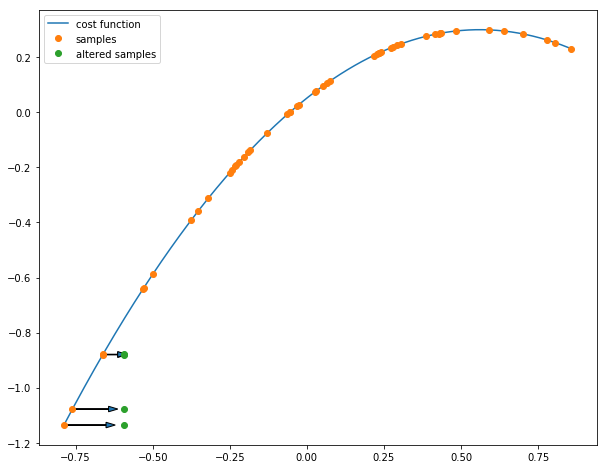

In [14]:
plot_sample_change(x_star,np.sort(Sy),new_sample,util.f1)

In [476]:
def wasserstein_constraint_convex(variables,bounds,samples,delta):
    """
    in convex functions, the limit is fixed,
    what we try to do is determine the number of samples to move
    to that limit and the fraction of movement
    
    variables[0] and variables[1] is the index, left and right respectively
    variables[2] and variables[3] are weights, elft and right respectively
    """
    #left = samples[:int(variables[0])+1] - bounds[0]
    # the last element is "fractionally" moved
    #left[-1] *= variables[2]
    left = samples[:np.searchsorted(samples,variables[0],'left')] - bounds[0]
    #left = samples[samples < variables[0]] - bounds[0]
    
    # do the same for the right side
    #right =  samples[int(variables[1])+1:] - bounds[1]
    right = bounds[1]- samples[np.searchsorted(samples,variables[1],'left'):]  
    #right = bounds[1] - samples[samples > variables[1]] 
    
    print right
    print left

    if left.shape[0] > 0:
        left[-1] *= variables[2]
        
    if right.shape[0] > 0:
        right[0] *= variables[3] 
        
    if right.shape[0] <= 1 and left.shape[0] <= 1:
        distance = 0.0
    else:
        distance =np.mean(np.concatenate((right[:-1], left[1:])))
    return distance-delta

In [477]:
def alter_samples_convex(limit,bounds,samples):
    
    new_samples = np.copy(samples)
    #new_samples[:np.searchsorted(samples,limit[0],'left')] = bounds[0]
    #new_samples[np.searchsorted(samples,limit[1],'right'):] = bounds[1]
    new_samples[samples < limit[0]] = bounds[0]
    new_samples[samples > limit[1]] = bounds[1]

    return new_samples

In [353]:
added_samples = np.insert(sort_Sy,[0,sort_Sy.shape[0]],[-1.0,1.0])

In [354]:
added_samples

array([-1.        , -0.70976326, -0.65859712, -0.60625061, -0.57639344,
       -0.49582434, -0.48796813, -0.47254933, -0.46138149, -0.3976364 ,
       -0.35797347, -0.33442128, -0.32535032, -0.28732917, -0.27741054,
       -0.27256382, -0.20160763, -0.19702831, -0.17940559, -0.17560546,
       -0.17466223, -0.10525637, -0.09298845, -0.08754827, -0.05567361,
       -0.04760166, -0.02261089, -0.01633299,  0.0114786 ,  0.01463854,
        0.04184438,  0.05520471,  0.10184153,  0.10624456,  0.18258839,
        0.19172843,  0.23133669,  0.30117998,  0.31890023,  0.36893528,
        0.37038242,  0.3759512 ,  0.39610955,  0.42042492,  0.5009669 ,
        0.52397473,  0.60405751,  0.67812705,  0.68859022,  0.72222638,
        0.79947959,  1.        ])

In [355]:
wasserstein_constraint_convex([-0.44,0.7,0.5,0.5],[-1.0,1.0],added_samples,delta)

4.639862974734573

In [356]:
new_samples = alter_samples_convex([-0.40,0.6],[-1.0,1.0],added_samples)

In [357]:
new_samples

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -0.3976364 ,
       -0.35797347, -0.33442128, -0.32535032, -0.28732917, -0.27741054,
       -0.27256382, -0.20160763, -0.19702831, -0.17940559, -0.17560546,
       -0.17466223, -0.10525637, -0.09298845, -0.08754827, -0.05567361,
       -0.04760166, -0.02261089, -0.01633299,  0.0114786 ,  0.01463854,
        0.04184438,  0.05520471,  0.10184153,  0.10624456,  0.18258839,
        0.19172843,  0.23133669,  0.30117998,  0.31890023,  0.36893528,
        0.37038242,  0.3759512 ,  0.39610955,  0.42042492,  0.5009669 ,
        0.52397473,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ])

In [358]:
added_samples

array([-1.        , -0.70976326, -0.65859712, -0.60625061, -0.57639344,
       -0.49582434, -0.48796813, -0.47254933, -0.46138149, -0.3976364 ,
       -0.35797347, -0.33442128, -0.32535032, -0.28732917, -0.27741054,
       -0.27256382, -0.20160763, -0.19702831, -0.17940559, -0.17560546,
       -0.17466223, -0.10525637, -0.09298845, -0.08754827, -0.05567361,
       -0.04760166, -0.02261089, -0.01633299,  0.0114786 ,  0.01463854,
        0.04184438,  0.05520471,  0.10184153,  0.10624456,  0.18258839,
        0.19172843,  0.23133669,  0.30117998,  0.31890023,  0.36893528,
        0.37038242,  0.3759512 ,  0.39610955,  0.42042492,  0.5009669 ,
        0.52397473,  0.60405751,  0.67812705,  0.68859022,  0.72222638,
        0.79947959,  1.        ])

In [359]:
test_convex([-0.4,0.6,0.5,0.5],[-1,1],x_star,added_samples,util.f2)

0.5055398131519805

In [478]:
def test_convex(variables,limit,x_star,samples,func):
    # just remember we have samples = [bound_neg, x0,x1,x2,...,xn,bound_pos]
    # assign the weights
    weights = np.ones((samples.shape[0]))
    # at the lefthand side, thr weight is a fraction of one
    if sum(samples<variables[0]) <= 1:
        weights[0] = 0
    else:
        weights[0] = variables[2]
        index = np.searchsorted(samples,variables[0],'left')
        weights[index-1] = 1 - variables[2]
        #weights[[samples<variables[0]][-1]] = 1 - variables[2]
    if sum(samples>variables[1]) <= 1:
        weights[-1] = 0
    else:
        weights[-1] = variables[3]
        index = np.searchsorted(samples,variables[1],'right')
        weights[index] = 1 - variables[3]
    print weights
    new_S = alter_samples_convex(variables[:2],limit,samples)
    return evaluate(x_star,new_S,func,weights=weights)

In [487]:
def wasser_robustification_convex(samples,sample_bounds,x_star,func):
    # sort the samples
    samples = np.sort(samples)
    # added limits for computations
    added_samples = np.insert(samples,[0,samples.shape[0]],[-1.0,1.0])
    
    # constraints and bounds
    constraint = [{'type':'ineq','fun':wasserstein_constraint_convex,
                   'args':[sample_bounds,added_samples,delta]},
             {'type':'ineq','fun':limit_constraint}]
            #{'type':'eq','fun': lambda x : max([x[i]-int(x[i]) for i in range(2)])}]
    bound = [sample_bounds,sample_bounds,(0,1),(0,1)]
    
    # initial guess
    # index 0, shape+1 means no movement,
    initial_variable = [samples[5],samples[-5],0.5,0.5]
    
    
    
    res = minimize(test_convex,initial_variable,args=(sample_bounds,x_star,added_samples,func),
                   constraints=constraint,bounds=bound,
                  options={'maxiter': 1000,
                          'ftol': 1e-06})
    new_samples = alter_samples_convex(res.x,sample_bounds,added_samples)
    return new_samples[1:-1],res.x

In [488]:
Sy = Y.rvs(50)
sort_Sy = np.sort(Sy)

In [489]:
delta = 5.0
x_star = SAA_minimise(sort_Sy,util.f2)

In [490]:
sample_bounds = [-1,1]
new_sample,var = wasser_robustification_convex(sort_Sy,sample_bounds,x_star,util.f2)

[0.42885841 0.41042773 0.32885888 0.14965098 0.13608635 0.        ]
[0.         0.28277663 0.2899489  0.35728368 0.35818622 0.46688191]
[0.5 1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  0.5]
[0.42885841 0.41042773 0.32885888 0.14965098 0.13608635 0.        ]
[0.         0.28277663 0.2899489  0.35728368 0.35818622 0.46688191]
[0.5 1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  0.5]
[0.5 1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  0.5]
[0.5 1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1

In [491]:
new_sample

array([-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -4.64401533e-01, -4.41442809e-01, -3.75682284e-01,
       -3.39357780e-01, -3.15372357e-01, -2.65424475e-01, -2.35328871e-01,
       -2.02580959e-01, -1.89379060e-01, -1.40228619e-01, -1.13251416e-01,
       -8.58832917e-02, -5.53723075e-02, -2.10376434e-02, -4.46150055e-03,
        1.50875565e-04,  2.33650946e-02,  5.10833210e-02,  6.58187863e-02,
        7.93536976e-02,  9.35607915e-02,  1.00908104e-01,  1.16137076e-01,
        1.18388446e-01,  1.25225857e-01,  1.50698598e-01,  1.68418661e-01,
        1.75591074e-01,  2.17516080e-01,  2.23503488e-01,  2.31047499e-01,
        2.88133215e-01,  3.03869379e-01,  3.52620884e-01,  3.74207237e-01,
        3.91531851e-01,  4.16573581e-01,  4.60745160e-01,  5.19180768e-01,
        5.47425446e-01,  5.71141587e-01,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00])

In [492]:
var

array([-0.46440153,  0.57114159,  0.5       ,  0.5       ])

In [493]:
wasserstein_constraint_convex(var,sample_bounds,added_samples,delta)

[0.39594249 0.32187295 0.31140978 0.27777362 0.20052041 0.        ]
[0.         0.29023674 0.34140288 0.39374939 0.42360656 0.50417566
 0.51203187 0.52745067]


-4.663460295832051

In [494]:
test_convex(var,sample_bounds,x_star,new_sample,util.f2)

[0.5 1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  0.5]


-1.3523973738934039